In [44]:
cellSize = 0.05
radius = 1.

In [45]:
from fipy import CellVariable, Gmsh2D, TransientTerm, DiffusionTerm, Viewer
from fipy.tools import numerix

In [46]:
mesh = Gmsh2D('''
              cellSize = %(cellSize)g;
              radius = %(radius)g;
              Point(1) = {0, 0, 0, cellSize};
              Point(2) = {-radius, 0, 0, cellSize};
              Point(3) = {0, radius, 0, cellSize};
              Point(4) = {radius, 0, 0, cellSize};
              Point(5) = {0, -radius, 0, cellSize};
              Circle(6) = {2, 1, 3};
              Circle(7) = {3, 1, 4};
              Circle(8) = {4, 1, 5};
              Circle(9) = {5, 1, 2};
              Line Loop(10) = {6, 7, 8, 9};
              Plane Surface(11) = {10};
              ''' % locals()) 

In [47]:
phi = CellVariable(name = "solution variable",
                   mesh = mesh,
                   value = 0.) 

<Figure size 640x480 with 0 Axes>

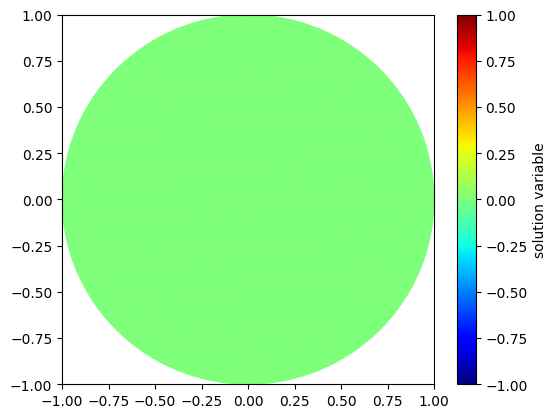

In [48]:
viewer = None
from fipy import input
if __name__ == '__main__':
    viewer = Viewer(vars=phi, datamin=-1, datamax=1.)
    viewer.plotMesh()

In [49]:
D = 1.
eq = TransientTerm() == DiffusionTerm(coeff=D)

In [50]:
X, Y = mesh.faceCenters 
phi.constrain(X, mesh.exteriorFaces) 


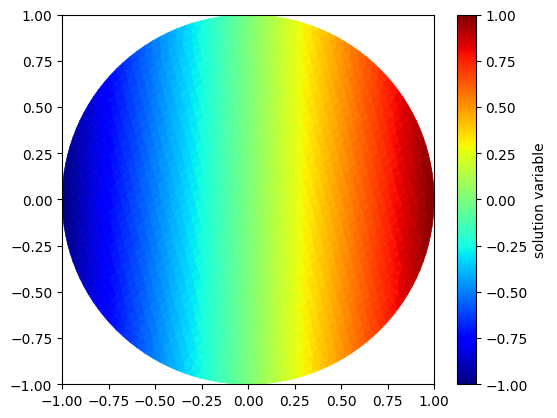

In [51]:
timeStepDuration = 10 * 0.9 * cellSize**2 / (2 * D)
steps = 50
from builtins import range
for step in range(steps):
    eq.solve(var=phi,
             dt=timeStepDuration) 
    if viewer is not None:
        viewer.plot() 

In [52]:
from fipy.viewers.tsvViewer import TSVViewer

TSVViewer(vars=(phi, phi.grad)).plot(filename="myTSV.tsv")


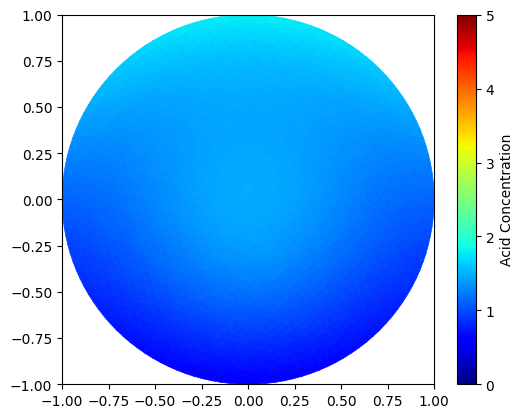

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# FiPy imports
from fipy import (
    CellVariable, FaceVariable,
    TransientTerm, DiffusionTerm, UpwindConvectionTerm,
    Gmsh2D, Viewer
)
from fipy.tools import numerix

# --- Create a circular mesh using Gmsh2D ---
cellSize = 0.05
radius = 1.0
mesh = Gmsh2D('''
              cellSize = %(cellSize)g;
              radius = %(radius)g;
              Point(1) = {0, 0, 0, cellSize};
              Point(2) = {-radius, 0, 0, cellSize};
              Point(3) = {0, radius, 0, cellSize};
              Point(4) = {radius, 0, 0, cellSize};
              Point(5) = {0, -radius, 0, cellSize};
              Circle(6) = {2, 1, 3};
              Circle(7) = {3, 1, 4};
              Circle(8) = {4, 1, 5};
              Circle(9) = {5, 1, 2};
              Line Loop(10) = {6, 7, 8, 9};
              Plane Surface(11) = {10};
              ''' % locals())

# --- Define the acid concentration variable ---
phi = CellVariable(name="Acid Concentration", mesh=mesh, value=0.0)

# --- Initial droplet placement ---
# Here the droplet is placed at the center (0,0) of the circular domain.
droplet_radius = 0.5  # choose a radius smaller than the domain's radius
x, y = mesh.cellCenters
phi.setValue(5.0, where=(x**2 + y**2) < droplet_radius**2)

# --- Diffusion coefficient ---
D = 1.0  # mm²/s

# --- Buoyancy-driven velocity field (simplified) ---
gravity = 1.0  # strength of buoyancy effect

# Create a single FaceVariable with rank=1 (holds both x and y components)
velocity = FaceVariable(mesh=mesh, rank=1, value=(0.0, 0.0))
# For this toy model, we define the vertical component based on phi.
# (Here we let regions with high phi drive a downward motion.)
velocity[1] = -gravity * (phi.faceValue - 2.5)

# --- Define the PDE ---
eq = (TransientTerm(var=phi) ==
      DiffusionTerm(var=phi, coeff=D) -
      UpwindConvectionTerm(var=phi, coeff=velocity))

# --- Set up the Viewer ---
# This viewer will display the evolving field on the circular mesh.
viewer = Viewer(vars=phi, datamin=0, datamax=5)
viewer.plotMesh()  # Optionally display the mesh structure

# --- Time stepping ---
dt = 0.001
steps = 200

for step in range(steps):
    # Solve the PDE for one time step
    eq.solve(var=phi, dt=dt)
    
    # Recalculate the velocity field after phi has changed.
    velocity[1] = -gravity * (phi.faceValue - 2.5)
    
    # Update the viewer with the new solution.
    viewer.plot()

# Hold the final plot (in some environments, you may need to close the window manually)
input("Simulation complete. Press Enter to exit.")


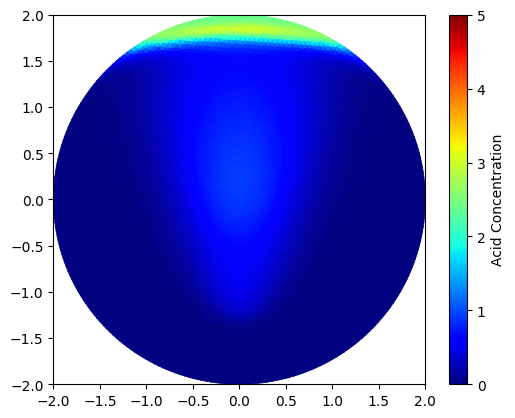

KeyboardInterrupt: 

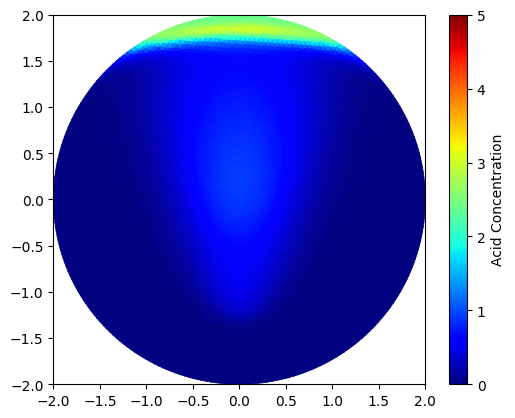

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# FiPy imports
from fipy import (
    CellVariable, FaceVariable,
    TransientTerm, DiffusionTerm, UpwindConvectionTerm,
    Gmsh2D, Viewer
)
from fipy.tools import numerix

# --------------------------------------------------------------
# 1. Mesh creation (circular 2D domain)
# --------------------------------------------------------------
cellSize = 0.05
radius = 2.0
mesh = Gmsh2D('''
cellSize = %(cellSize)g;
radius = %(radius)g;
Point(1) = {0, 0, 0, cellSize};
Point(2) = {-radius, 0, 0, cellSize};
Point(3) = {0, radius, 0, cellSize};
Point(4) = {radius, 0, 0, cellSize};
Point(5) = {0, -radius, 0, cellSize};
Circle(6) = {2, 1, 3};
Circle(7) = {3, 1, 4};
Circle(8) = {4, 1, 5};
Circle(9) = {5, 1, 2};
Line Loop(10) = {6, 7, 8, 9};
Plane Surface(11) = {10};
''' % locals())

# --------------------------------------------------------------
# 2. Define the acid concentration variable
# --------------------------------------------------------------
phi = CellVariable(name="Acid Concentration", mesh=mesh, value=0.0)

# --------------------------------------------------------------
# 3. Initial droplet placement at center
# --------------------------------------------------------------
droplet_radius = 0.5
x, y = mesh.cellCenters
phi.setValue(5.0, where=(x**2 + y**2) < droplet_radius**2)

# --------------------------------------------------------------
# 4. Physical parameters
# --------------------------------------------------------------
D = 1.0          # diffusion coefficient
gravity = 9.81   # gravitational acceleration (mimicking real units)
phi_ref = 2.5    # reference concentration around which buoyancy "turns on"
scaleFactor = 1.0  # scales the strength of the buoyancy effect in 2D

# --------------------------------------------------------------
# 5. Define a 2D velocity field "mimicking" 3D buoyancy
# --------------------------------------------------------------
velocity = FaceVariable(mesh=mesh, rank=1, value=(0.0, 0.0))

# We interpret 'velocity[1]' as the "vertical" component in this 2D plane.
# The formula is a toy model: velocity_y ~ -g * (phi - phi_ref)
# multiplied by a scaleFactor that you can tune to better mimic 3D behavior.
velocity[1] = -scaleFactor * gravity * (phi.faceValue - phi_ref)

# --------------------------------------------------------------
# 6. PDE: Transient diffusion + upwind convection
# --------------------------------------------------------------
eq = (TransientTerm(var=phi)
      == DiffusionTerm(var=phi, coeff=D)
      - UpwindConvectionTerm(var=phi, coeff=velocity))

# --------------------------------------------------------------
# 7. Visualization
# --------------------------------------------------------------
viewer = Viewer(vars=phi, datamin=0, datamax=5)
viewer.plotMesh()  # visualize the mesh structure (optional)

# --------------------------------------------------------------
# 8. Time stepping
# --------------------------------------------------------------
dt = 0.01
steps = 200

for step in range(steps):
    # Solve PDE for one time step
    eq.solve(var=phi, dt=dt)
    
    # Update velocity to reflect new concentration
    velocity[1] = -scaleFactor * gravity * (phi.faceValue - phi_ref)
    
    # Plot the updated concentration field
    viewer.plot()

# Keep the window open at the end
input("Simulation complete. Press Enter to exit.")


ValueError: could not broadcast input array from shape (2,) into shape (2,104)

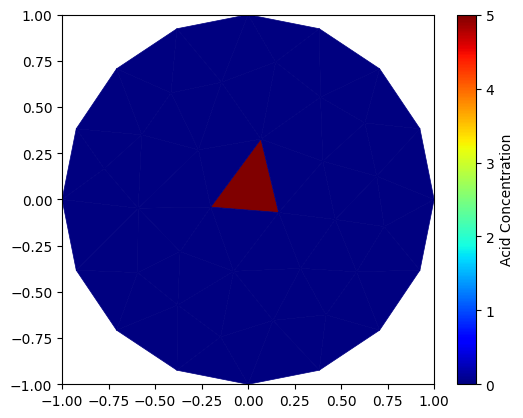

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# FiPy imports
from fipy import (
    CellVariable, FaceVariable,
    TransientTerm, DiffusionTerm, UpwindConvectionTerm,
    Gmsh2D, Viewer
)
from fipy.tools import numerix

###############################################################################
# 1. CREATE THE CIRCULAR MESH
###############################################################################
cellSize = 0.5
radius = 1.0
mesh = Gmsh2D('''
              cellSize = %(cellSize)g;
              radius = %(radius)g;
              Point(1) = {0, 0, 0, cellSize};
              Point(2) = {-radius, 0, 0, cellSize};
              Point(3) = {0, radius, 0, cellSize};
              Point(4) = {radius, 0, 0, cellSize};
              Point(5) = {0, -radius, 0, cellSize};
              Circle(6) = {2, 1, 3};
              Circle(7) = {3, 1, 4};
              Circle(8) = {4, 1, 5};
              Circle(9) = {5, 1, 2};
              Line Loop(10) = {6, 7, 8, 9};
              Plane Surface(11) = {10};
              ''' % locals())

###############################################################################
# 2. DEFINE THE ACID CONCENTRATION VARIABLE & INITIAL CONDITION
###############################################################################
phi = CellVariable(name="Acid Concentration", mesh=mesh, value=0.0)

droplet_radius = 0.1
x, y = mesh.cellCenters
phi.setValue(5.0, where=(x**2 + y**2) < droplet_radius**2)

###############################################################################
# 3. PARAMETERS & VELOCITY (TOY BUOYANCY MODEL)
###############################################################################
D       = 1.0      # diffusion coefficient
gravity = 1.0      # "strength" of buoyancy effect
refC    = 2.5      # reference concentration offset for velocity

# Create a FaceVariable for velocity with zero initial value
velocity = FaceVariable(mesh=mesh, rank=1, value=(0.0, 0.0))

###############################################################################
# 4. DEFINE THE PDE FOR ACID TRANSPORT
###############################################################################
#  ∂phi/∂t = D ∇²(phi) − ∇·(phi * velocity)
# using an UpwindConvectionTerm for stability
eq = (
    TransientTerm(var=phi)
    == DiffusionTerm(var=phi, coeff=D)
    - UpwindConvectionTerm(var=phi, coeff=velocity)
)

###############################################################################
# 5. VIEWER SETUP
###############################################################################
viewer = Viewer(vars=phi, datamin=0, datamax=5)
viewer.plotMesh()  # optionally show the mesh lines

###############################################################################
# 6. TIME STEPPING
###############################################################################
dt    = 0.01
steps = 200

for step in range(steps):
    eq.solve(var=phi, dt=dt)

    face_conc = phi.faceValue
    velY = -gravity * (face_conc - refC)
    velX = numerix.zeros_like(velY)

    interior_faces = numerix.logical_not(mesh.exteriorFaces.value)

    # Reset all velocities to zero
    velocity.setValue((0., 0.))
    
    # Build an array matching FiPy's shape expectations
    vel_data = numerix.array((velX.value, velY.value))  # shape is (2, nFaces)
    velocity.setValue(vel_data.T, where=interior_faces)  # shape becomes (nFaces, 2)

    viewer.plot()
    plt.pause(0.001)

input("Simulation complete. Press Enter to exit.")

KeyboardInterrupt: 

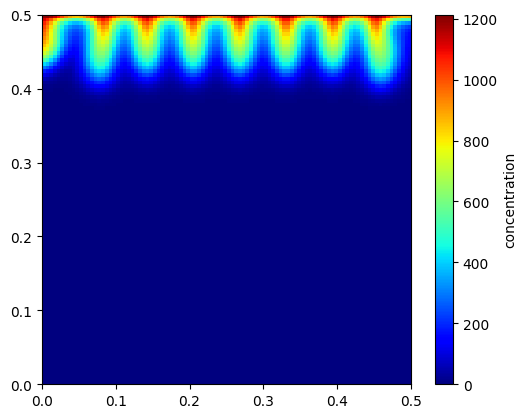

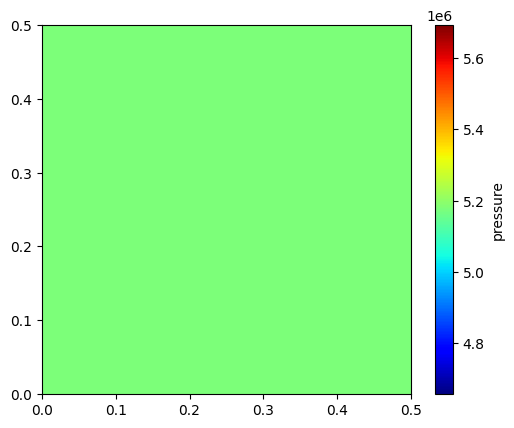

In [6]:
from fipy import *
from fipy.variables.cellVariable import CellVariable
from fipy import numerix
# Geometry and sizes
H = 0.5
W = 0.5
m = 100
n = 100
dx = W/m
dy = H/n

# physical constants
D = 2.0e-9
k = 10.0e-12
mu = 1e-3
P0 = 51.75e5
g = 9.81
b1 = 1.1803e-02
b2 = 9.9334e+02
poros = 0.38



# mesh
mesh = Grid2D(nx = m, ny = n, dx = dx, dy = dy)

# variable
gravity = FaceVariable(mesh = mesh, rank = 1, value = ((0,),(-g,)))

c = CellVariable(name = 'concentration', mesh = mesh, hasOld=True, rank = 0, value = 0.)
p = CellVariable(name = 'pressure', mesh = mesh, value = P0)
rho = CellVariable(name = 'density', mesh = mesh, value = c.value*b1+b2)
#rho.setValue(c.value*b1+b2)

# equation
eqp = (DiffusionTerm(coeff = k/mu) - (k/mu*(b1*c.faceValue+b2)*gravity).divergence == 0)

eqc = (TransientTerm(coeff = poros) - DiffusionTerm(coeff = poros*D)
                        + UpwindConvectionTerm(coeff = -k/mu*(p.faceGrad-(b1*c.faceValue+b2)*gravity))==0)                        

#Boundary conditions
LeftFlux = 0.
RightFlux = 0.
BottomFlux = 0.
TopConc = 1200.
#c.getCellVolumeAverage().
x, y = mesh.faceCenters
facetop = mesh.facesTop
facebottom = mesh.facesBottom
faceleft = mesh.facesLeft
faceright = mesh.facesRight
cb = c.faceValue

c.constrain(TopConc*(1.+numerix.sin(x/W*50.)/10.), facetop)
c.faceGrad.constrain(LeftFlux, faceleft)
c.faceGrad.constrain(RightFlux, faceright)
c.faceGrad.constrain(BottomFlux, facebottom)

#p.constrain(P0, facetop)
p.faceGrad.constrain(0., faceleft)
p.faceGrad.constrain(0., faceright)
p.faceGrad.constrain(-g*(b1*cb+b2), facebottom)
p.faceGrad.constrain(-g*(b1*cb+b2), facetop)

# solver values
viewer = Viewer(vars = c)
viewerp = Viewer(vars = p)
viewer.plot()
timestep = 5000.
steps = 20000
eqp.solve(var = p)    

for step in range(steps):
    c.updateOld()
    cres = 1.0e6
    pres = 1.0e6
    while cres > 1e-6:
        eqp.solve(var = p)        
        cres = eqc.sweep(var = c, dt = timestep)
    print(step*timestep)
    viewer.plot()
